<a href="https://colab.research.google.com/github/weisben/Deutch-Jozsa-IBM-Error/blob/main/DeutschJozsaError.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing IBM's error rates using the Deutsch-Jozsa Algorithm

In this demo, I am testing the error rates of IBM's quantum computers when running the Deutch-Jozsa algorithm. First, we need to install some packages. If the imports do not work, try restarting the kernel.

In [ ]:
installed = False
if not installed:
  !pip install qiskit
  !pip install qiskit-aer
  !pip install pylatexenc
  !pip install qiskit-ibmq-provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=55cd07ef453a047e9f2b591ad2a0d6a505a3b1186b37ec8e115906b4e63c8f2c
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.providers.ibmq import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.tools.monitor import *

## Implementing the Algorithm

The Deutsch-Jozsa algorithm determines whether a function $f: \{0,1\}^n\rightarrow\{0,1\}$ is even or balanced. So first, we need to generate the function $f$. The method below creates the circuit for a random even or balanced function given the desired number of bits.

In [ ]:
# Defines circuit for Uf
# n = # qubits
# func_type = "even"/"balanced"
def create_Uf(n, func_type):
  circuit = QuantumCircuit(n+1)

  # Even function
  if(func_type == "even"):
    # Randomly decide output - either 0 or 1
    output = np.random.randint(2)
    if output == 1:
      circuit.x(n)

  # Balanced function
  if(func_type == "balanced"):
    ## Randomly decide which bits to flip
    x_encoding = np.random.randint(0, 2, n)
    for qubit in range(n):
        if x_encoding[qubit] == 1:
            circuit.x(qubit)
    for qubit in range(n):
        circuit.cx(qubit, n)
    for qubit in range(n):
        if x_encoding[qubit] == 1:
            circuit.x(qubit)

  circuit.draw('mpl', style='clifford')
  circuit.name = "Uf"

  return circuit

Let's see an example of a function in action. Qiskit allows us to print out the circuit we created to see what is happening. Note that there are only two possible functions for even functions (either it always outputs 0 or it always outputs 1), while there are $2^n$ possible functions for balanced functions.

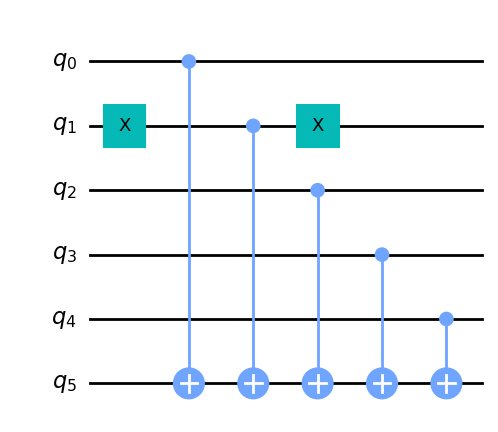

In [ ]:
n = 5
func_type = "balanced"

Uf = create_Uf(n, func_type)
Uf.draw('mpl', style='clifford')

We can also test that the function is truly even or balanced by simulating it.. Here, I've put the $A$ system into an equal superposition and added a measurement to the $B$ system qubit to see whether the function is outputting $0$ or $1$ for a given input.

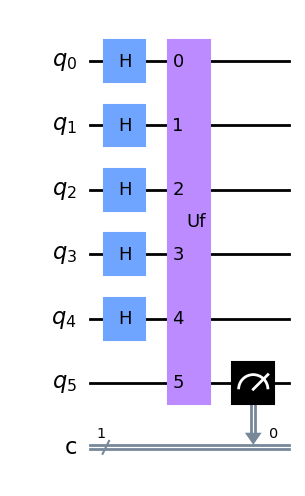

In [ ]:
function_tester = QuantumCircuit(n+1, 1)
function_tester.h(range(n))
function_tester.append(Uf, range(n+1))
function_tester.measure(n,0)
function_tester.draw('mpl', style='clifford')

In order to run the circuit, we need to "transpile" it with a specified backend. We will use the Aer simulator for this, which does not use real quantum computers and thus has no errors. Qiskit gives us a useful function for plotting the results of the simulation, which gives us the counts of each possible outcome. For even functions, we should only get one outcome, and for balanced functions, we should get about half 0s and half 1s.

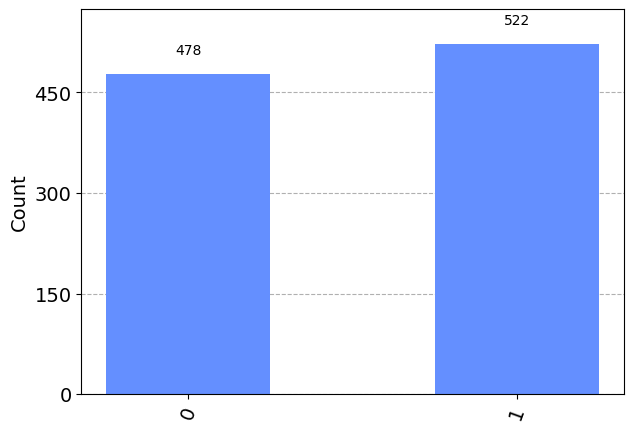

In [ ]:
simulator = Aer.get_backend('aer_simulator')
transpiled_tester = transpile(function_tester, simulator)
results = simulator.run(transpiled_tester, shots = 1000).result()
counts = results.get_counts()
plot_histogram(counts)

Now, we can define a function for creating the Deutch-Jozsa (DJ) algorithm using a given $U_f$ circuit. This involves applying the $H^{\otimes n}$ gate to the $A$ system and the $X$ and $H$ gates to the $B$ system before apply the $U_f$ circuit. Then we apply $H^{\otimes n}$ to the $A$ system again before measuring.

In [ ]:
def create_DJ(Uf):
    n = Uf.num_qubits - 1
    circuit = QuantumCircuit(n+1, n)

    # Apply X to B system
    circuit.x(n)
    # Apply H to both systems
    for qubit in range(n+1):
        circuit.h(qubit)

    # Apply Uf
    circuit.append(Uf, range(n+1))

    # Apply H again to A system
    for qubit in range(n):
        circuit.h(qubit)

    # Measure
    for i in range(n):
        circuit.measure(i, i)

    return circuit

We can test this out by creating an example DJ algorithm on the $U_f$ circuit we created.

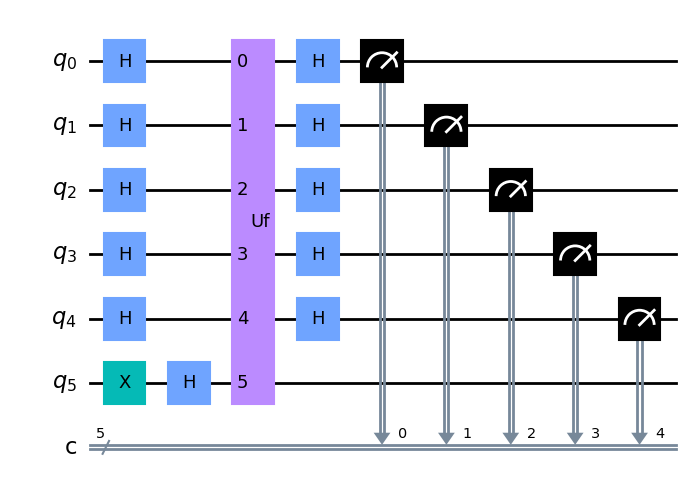

In [ ]:
DJ = create_DJ(Uf)
DJ.draw('mpl', style = 'clifford')

When we simulate the algorithm on a fake quantum computer, we should always get the correct answer, which is all 0s if even and all 1s if balanced.

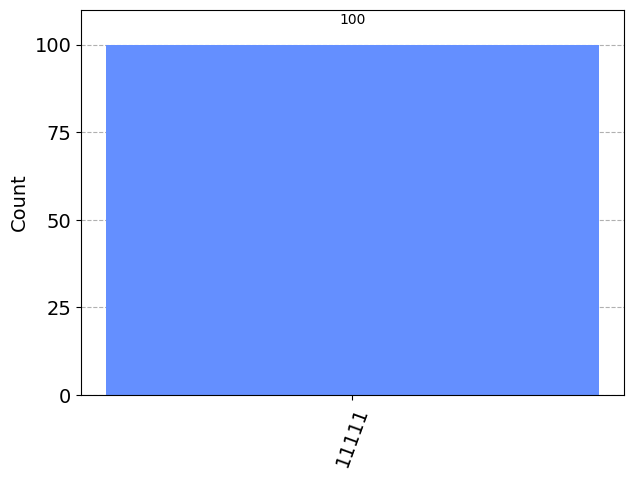

In [ ]:
transpiled_DJ = transpile(DJ, simulator)
results = simulator.run(transpiled_DJ, shots = 100).result()
answer = results.get_counts()
plot_histogram(answer)

Using the Aer simulator, we always get the correct outcome. But how would this algorithm perform with real quantum computers? Let's see!

## Testing on Real Quantum Computers

Now, let's see how IBM's quantum computers perform on this algorithm. First, we need to specify an API key that comes from creating an IBM Quantum account. You get about 10 minutes of free credits - so far I have used about 3 minutes from running this notebook many times.

In [ ]:
# My IBM API code - use once or twice if you want or consider creating your own account!
IBMQ.save_account("d484d1cee1b1e61cbbfe505e4fda044514d51aaaeb2eaeac38c68d153eb9c6603edbad820aa18ca5f730b8017d5d776e92b783503f25c5150c6879a7919abd84")
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

Now, we can connect to a real quantum computer backend! The code below allows us to access the least busy one with a few filters: it must have enough qubits, not be a simulator, and be operational.

In [ ]:
backend = least_busy(provider.backends(filters=lambda x:
                                        x.configuration().n_qubits >= n+1 and
                                        not x.configuration().simulator and
                                        x.status().operational))
print(backend)

ibm_osaka


Let's try running the DJ circuit we created previously on a real quantum computer. Now, there will be some error.

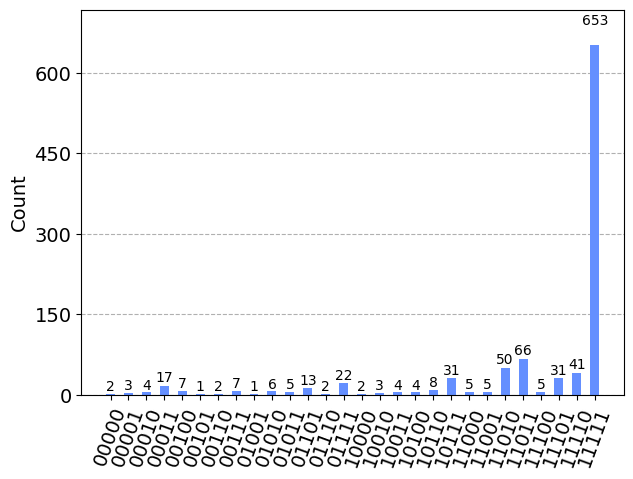

In [ ]:
transpiled_DJ_real = transpile(DJ, backend, optimization_level=3)
job = backend.run(transpiled_DJ_real, shots = 1000)
counts = job.result().get_counts()

plot_histogram(counts)

What's the error rate? We can calculate the proportion of outcomes that were not the desired result.

In [ ]:
sum = 0
for key in counts:
  sum += (counts.get(key))

truth = "0"*n if func_type == "even" else "1"*n

error_rate = 1 - counts.get(truth) / sum
error_rate

0.347

Let's see how the error rate changes with the number of qubits. Below is a function for calculating this error rate for a single run of the algorithm.

In [ ]:
# Calculates the error rate for a DJ algorithm with n qubits, Uf of type func_type
# shots controls how many times the circuit runs
# isReal controls whether the function uses a real backend on a simulator
def calc_error(n, func_type, shots, isReal):
    Uf = create_Uf(n, func_type)
    DJ = create_DJ(Uf)

    if isReal:
      backend = least_busy(provider.backends(filters=lambda x:
                                              x.configuration().n_qubits >= n+1 and
                                              not x.configuration().simulator and
                                              x.status().operational))
    else:
      backend = Aer.get_backend('aer_simulator')

    transpiled_DJ = transpile(DJ, backend, optimization_level=3)
    job = backend.run(transpiled_DJ, shots = shots)
    counts = job.result().get_counts()

    # Desired outcome will be all 0s or all 1s depending on function type
    truth = "0"*n if func_type == "even" else "1"*n
    error_rate = 1 - (counts.get(truth) / shots)

    return error_rate

Now, we can test the error rates for different numbers of qubits and different function types and compare!

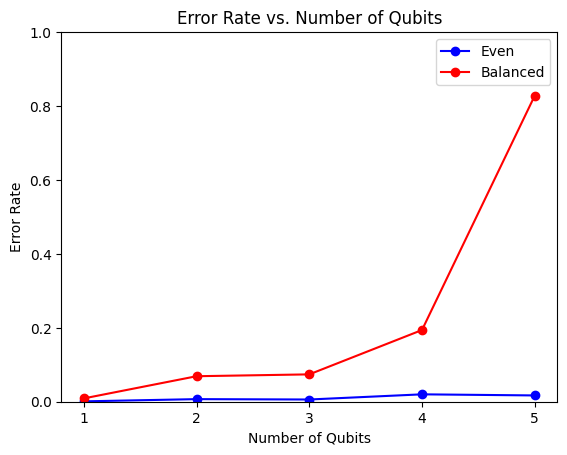

In [ ]:
shots = 1000
isReal = True # use sparingly
max_qubits = 5

n_seq = range(1, max_qubits+1)

# Calculate error rates for each number of qubits for each type of function
error_rates_even = [calc_error(n, "even", shots, isReal) for n in n_seq]
error_rates_balanced = [calc_error(n, "balanced", shots, isReal) for n in n_seq]

# Plot the results
plt.plot(n_seq, error_rates_even, marker='o', linestyle='-', color='b', label='Even')
plt.plot(n_seq, error_rates_balanced, marker='o', linestyle='-', color='r', label='Balanced')
plt.xticks(n_seq)
plt.ylim(0,1)
plt.legend()
plt.title('Error Rate vs. Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('Error Rate')
plt.grid(False)
plt.show()

Looks like for even functions, the error rate is always low, while for balanced functions it rises quite quickly with the number of qubits. This is an interesting result - I would love to look into why the error rates are so different.

## References

https://docs.quantum.ibm.com/

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/deutsch-jozsa.ipynb